In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split,cross_val_score
#model selection from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
#pca
from sklearn.decomposition import PCA
#data_balance
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [4]:
import os
os.chdir(r'C:\Users\VISHY\Desktop\Great Learning\Capstone\Vehicle-Loan-Default-Prediction\Data')

df = pd.read_csv('train.csv')

df=df.drop(['UniqueID','MobileNo_Avl_Flag'],axis=1)

In [5]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d1,d2

risk_map = {'No Bureau History Available':0, 
              'Not Scored: No Activity seen on the customer (Inactive)':0,
              'Not Scored: Sufficient History Not Available':0,
              'Not Scored: No Updates available in last 36 months':0,
              'Not Scored: Only a Guarantor':0,
              'Not Scored: More than 50 active Accounts found':0,
              'Not Scored: Not Enough Info available on the customer':0,
              'Very Low Risk':4,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

sub_risk = {'unknown':0, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk'],df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'credit_risk_label'] = df['credit_risk'].apply(lambda x: risk_map[x])
df.loc[:,'sub_risk_label'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'employment_label'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk', 'credit_risk_grade','Employment.Type'],axis=1)

In [6]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [7]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [8]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

## Stats

In [75]:
x=df.drop('loan_default',axis=1)

In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
feats=[]
vif=0
for i in range(x.shape[1]):
    vif=variance_inflation_factor(x.values, i)
    print(x.columns[i],"         ", vif)
    if (vif>10):
        feats.append(x.columns[i])
print(feats)

disbursed_amount           22.826208425185122
ltv           46.32249477428706
branch_id           2.183232069061153
manufacturer_id           10.678790232313444
Current_pincode_ID           3.728825371881061
State_ID           3.9673051907494594
Employee_code_ID           3.5761251182121567
Aadhar_flag           28.135906747251592
PAN_flag           1.1363918363514285
VoterID_flag           5.211578591388776
Driving_flag           1.490875180238482
Passport_flag           1.0474198645502713
PRI.NO.OF.ACCTS           3.2195591224951916
PRI.ACTIVE.ACCTS           5.748753958098962
PRI.OVERDUE.ACCTS           1.7880035915030983
PRI.CURRENT.BALANCE           1.5743567234015503
PRI.DISBURSED.AMOUNT           1.296880905305863
SEC.NO.OF.ACCTS           3.4749000377879313
SEC.ACTIVE.ACCTS           3.7769655528132127
SEC.OVERDUE.ACCTS           1.4362019295197335
SEC.CURRENT.BALANCE           7.6117264849828565
SEC.DISBURSED.AMOUNT           8.271729445484562
PRIMARY.INSTAL.AMT           1.09

In [9]:
df=df.drop(['asset_cost','credit_risk_label','PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT'],axis=1)

In [10]:
df=df.drop(['PERFORM_CNS.SCORE','supplier_id'],axis=1)

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

In [32]:
df.columns

Index(['disbursed_amount', 'ltv', 'branch_id', 'manufacturer_id',
       'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'sub_risk_label', 'employment_label', 'Age'],
      dtype='object')

In [43]:
num_cols=['disbursed_amount','PRI.NO.OF.ACCTS','PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Age']
cat_cols=['branch_id', 'manufacturer_id',
       'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag','sub_risk_label', 'employment_label']

In [61]:
c = SelectKBest(score_func=chi2, k=12)
catcols = c.fit(df[cat_cols],df['loan_default'])
n = SelectKBest(score_func=f_classif, k=10)
numcols=n.fit(df[num_cols],df['loan_default'])

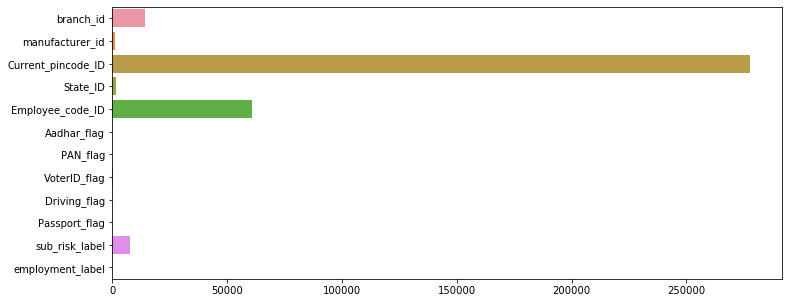

In [69]:
catsc=catcols.scores_
plt.figure(figsize=(12,5))
sns.barplot(x=catsc,y=cat_cols)

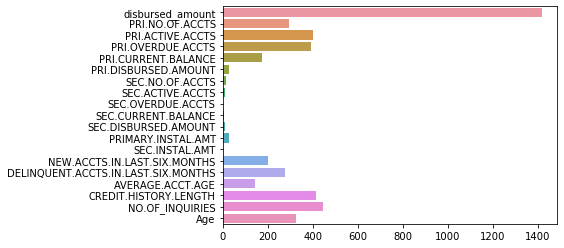

In [64]:
sns.barplot(x=numcols.scores_,y=num_cols)

In [71]:
from scipy.stats import chi2_contingency

for i in cat_cols:
    pvalue  = chi2_contingency(pd.crosstab(df[i],df['loan_default']))[1]
    print(i,pvalue)

branch_id 0.0
manufacturer_id 1.5277380091688753e-93
Current_pincode_ID 0.0
State_ID 0.0
Employee_code_ID 0.0
Aadhar_flag 1.1791998402218374e-89
PAN_flag 0.3277743362589148
VoterID_flag 5.603683381655361e-99
Driving_flag 0.0052012912081583085
Passport_flag 0.0002987981770071958
sub_risk_label 0.0
employment_label 3.1225422343284505e-42


In [153]:
from scipy.stats import ttest_ind

for i in num_cols:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    print(i,pvalue)

disbursed_amount 8.74561717585509e-309
PRI.NO.OF.ACCTS 9.576575137572993e-66
PRI.ACTIVE.ACCTS 3.448627479875517e-89
PRI.OVERDUE.ACCTS 9.138488408377107e-87
PRI.CURRENT.BALANCE 6.221337646272035e-40
PRI.DISBURSED.AMOUNT 7.176942237800462e-08
SEC.NO.OF.ACCTS 5.1490255376949666e-05
SEC.ACTIVE.ACCTS 0.003805646152419518
SEC.OVERDUE.ACCTS 0.5081054926877384
SEC.CURRENT.BALANCE 0.0075643427363124875
SEC.DISBURSED.AMOUNT 0.0025523226185338705
PRIMARY.INSTAL.AMT 2.958254960232989e-07
SEC.INSTAL.AMT 0.4546434321302706
NEW.ACCTS.IN.LAST.SIX.MONTHS 9.30229371021266e-46
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS 3.2892517686894386e-62
AVERAGE.ACCT.AGE 5.261091482095756e-33
CREDIT.HISTORY.LENGTH 4.6500173864982836e-92
NO.OF_INQUIRIES 7.912566786376203e-99
Age 1.6119724395993934e-72


In [11]:
df=df.drop(['SEC.OVERDUE.ACCTS','SEC.INSTAL.AMT','PAN_flag'],axis=1)

In [70]:
catsc

array([1.42125088e+04, 1.03815866e+03, 2.77680338e+05, 1.49069966e+03,
       6.10693030e+04, 6.44069100e+01, 9.02570591e-01, 3.81535253e+02,
       7.71788310e+00, 1.34465204e+01, 7.93877514e+03, 9.75925002e+01])

In [12]:
df_pivot=pd.pivot_table(df, values=['ltv'],index='manufacturer_id',columns=['loan_default'],aggfunc='mean')
df_pivot=df_pivot['ltv'].sort_values(by=1, ascending=False)

In [13]:
df_pivot['Count']=df['manufacturer_id'].value_counts()

df_pivot

loan_default,0,1,Count
manufacturer_id,,,
86,76.393866,79.736777,109534
45,75.391333,78.602826,56626
120,72.980345,75.330544,9658
51,70.633837,72.725876,27204
48,68.009257,69.942563,16710
145,68.549727,69.208590,778
49,66.178054,68.448292,10220
67,62.239830,62.380918,2405
153,48.510000,48.272500,12


In [155]:
df.columns

Index(['disbursed_amount', 'ltv', 'branch_id', 'manufacturer_id',
       'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'sub_risk_label', 'employment_label', 'Age'],
      dtype='object')

In [194]:
y=df['loan_default']
x=df.drop('loan_default',axis=1)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(xs, y, test_size=0.30, random_state=42)

In [196]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [197]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [198]:
# for Test set
model_score = lr.score(X_test,y_test)
print(model_score)
print("precision :",precision_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")

0.7826068308862424
precision : 0.45664739884393063 

f1 score: 0.010283780265555844 



In [205]:
from xgboost import XGBClassifier

In [201]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(criterion='entropy',random_state=0),
    DecisionTreeClassifier(criterion='gini',random_state=0),
    RandomForestClassifier(n_estimators=100),
    GaussianNB(),
    BaggingClassifier(random_state=0),
    AdaBoostClassifier(),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,
                  n_estimators=100, max_depth=3)
]

In [202]:
results = []
for item in classifiers:
    print(item,"\n")
    clf = item
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    #print(y_pred)
    #results.append(accuracy_score(y_test,y_pred))
    results.append(y_pred)
    print("accuracy train:",clf.score(X_train,y_train),"\n")
    print("accuracy test:",clf.score(X_test,y_test),"\n")
    print("precision :",precision_score(y_test,y_pred),"\n")
    print("f1 score:",f1_score(y_test,y_pred),"\n")
    print("-------------------------------------------------------------------------------------------------------")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

accuracy train: 0.7825828549020569 

accuracy test: 0.7826068308862424 

precision : 0.45664739884393063 

f1 score: 0.010283780265555844 

-------------------------------------------------------------------------------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best') 


In [206]:
sm = SMOTE(random_state=40)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [207]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(criterion='entropy',random_state=0),
    DecisionTreeClassifier(criterion='gini',random_state=0),
    RandomForestClassifier(n_estimators=100),
    GaussianNB(),
    BaggingClassifier(random_state=0),
    AdaBoostClassifier(),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,
                  n_estimators=100, max_depth=3)
]

In [208]:
results = []
for item in classifiers:
    print(item,"\n")
    clf = item
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    #print(y_pred)
    #results.append(accuracy_score(y_test,y_pred))
    results.append(y_pred)
    print("accuracy train:",clf.score(X_train,y_train),"\n")
    print("accuracy test:",clf.score(X_test,y_test),"\n")
    print("precision :",precision_score(y_test,y_pred),"\n")
    print("f1 score:",f1_score(y_test,y_pred),"\n")
    print("-------------------------------------------------------------------------------------------------------")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

accuracy train: 0.601946989912902 

accuracy test: 0.5713468769210974 

precision : 0.28318480300187615 

f1 score: 0.39186256414416964 

-------------------------------------------------------------------------------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best') 

a

In [212]:
(df == 0).astype(int).sum(axis=1)

0         20
1         10
2         21
3         14
4         19
          ..
233149    12
233150    16
233151    20
233152    20
233153    20
Length: 233154, dtype: int64